# 使用 Bagpipes 构建模型

本示例演示如何生成模型星系谱。主要有两步：定义要模拟的星系物理参数，以及定义想要预测的观测量（光谱和/或光度）。

在拟合观测数据之前，需要理解此处使用的语法。更多信息见文档中的 制作模型星系 页面 (making model galaxies)。

## model_components 字典

用于描述要构建何种模型的指令通过 model_components 字典传递。每个"组件"都是一个子字典，包含关于恒星形成历史、尘埃模型或星云发射模型的信息。也可以指定一些全局属性。唯一必需的组件是观测红移（redshift）和至少一个恒星形成历史组件。

下面示例展示了如何用 Calzetti 灰尘和一个简单的 tau 模型进行设置。

In [ ]:
import bagpipes as pipes
import numpy as np


exp = {}                          # 指数衰减（tau）星形成历史组件
exp["age"] = 3.                   # 单位：Gyr
exp["tau"] = 0.75                 # 单位：Gyr
exp["massformed"] = 9.            # log10(恒星质量 / M_solar)
exp["metallicity"] = 0.5          # 金属度（相对于旧太阳）

dust = {}                         # 尘埃/消光 组件
dust["type"] = "Calzetti"         # 定义消光曲线的形式
dust["Av"] = 0.2                  # 消光幅度，单位：星等

model_components = {}                   # model_components 字典
model_components["redshift"] = 1.0      # 观测红移

# 将两个子字典添加到 model_components 中
model_components["exponential"] = exp   
model_components["dust"] = dust

# model_components["nebular"] = { "logU": -3.0, "fesc": 0.0 }


Bagpipes: Latex turned off in rcParams, plots may look strange.


## 定义滤光曲线

若想获得上述参数对应对象的光度通量预测，首先需要定义一个滤光曲线列表（filt_list），供代码计算光度通量。

filt_list 包含从当前工作目录（或绝对路径）到滤光曲线文件的路径。滤光曲线文件应以波长（Å）列开始，后面跟相对透过率列。

注意：不同望远镜的滤光片参数有所不同，如果你使用的数据来源于不同探测器，请前往SVO寻找对应的文件替换
SVO:https://svo2.cab.inta-csic.es/theory/fps/

在这些示例中我们使用 Guo et al. (2013) 的 CANDELS GOODS South 目录，滤镜如下：

In [2]:
goodss_filt_list = ["filters/VIMOS_U",
                    "filters/f435w",
                    "filters/f606w",
                    "filters/f775w",
                    "filters/f850lp",
                    "filters/f098m",
                    "filters/f105w",
                    "filters/f125w",
                    "filters/f160w",
                    "filters/ISAAC_Ks",
                    "filters/HAWKI_K",
                    "filters/IRAC1",
                    "filters/IRAC2",
                    "filters/IRAC3",
                    "filters/IRAC4"]

我通常把这些保存在文本文件中，然后将其作为数组加载：

In [3]:
goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str")
goodss_filt_list

array(['filters/VIMOS_U', 'filters/f435w', 'filters/f606w',
       'filters/f775w', 'filters/f850lp', 'filters/f098m',
       'filters/f105w', 'filters/f125w', 'filters/f160w',
       'filters/ISAAC_Ks', 'filters/HAWKI_K', 'filters/IRAC1',
       'filters/IRAC2', 'filters/IRAC3', 'filters/IRAC4'], dtype='<U16')

## 构建模型

现在可以生成我们的模型星系了。命令如下：

In [4]:
model = pipes.model_galaxy(model_components, filt_list=goodss_filt_list)
# 注：如果执行后报错fesc未定义，请修改源码，或者将字典的nebular键取消注释再试。
# 源码的model_galaxy.py文件中fesc和nebular的kay键没有初始化，因此在构建没有星云发射的简单模型时可能会报错


快速绘图查看模型光谱和恒星形成历史：

bagpipes提供了封装好的plot函数库。但在研究工作中我不推荐你使用它

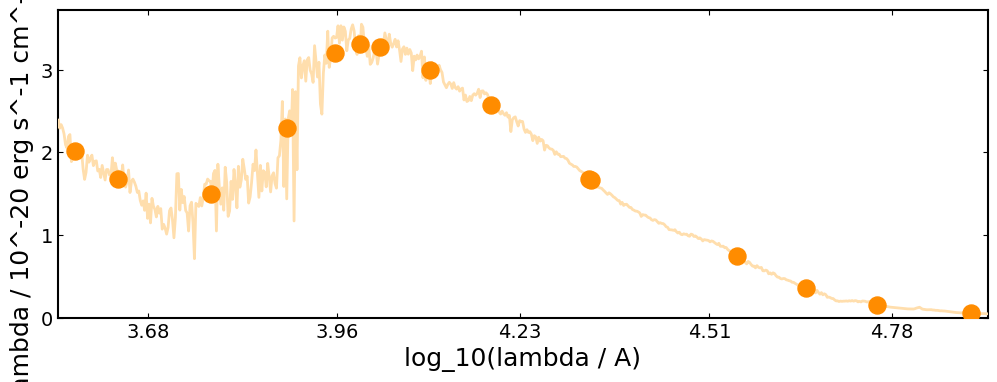

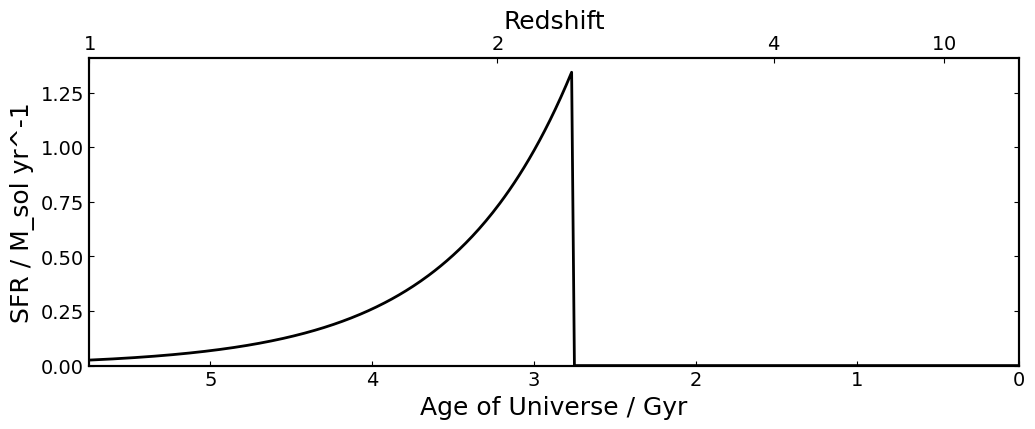

In [14]:
fig = model.plot()
fig = model.sfh.plot()


官方封装的plot函数难以调整绘图风格，我建议自己调用matplotlib绘制图像
例如：

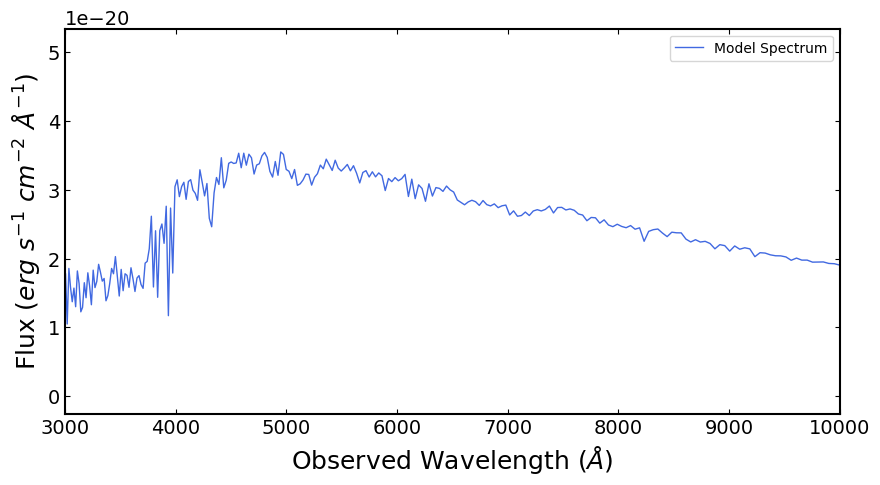

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# 绘制光谱
# 注意：spectrum_full 的单位通常是 erg/s/cm^2/A
ax.plot(model.wavelengths, model.spectrum_full, color='royalblue', lw=1, label='Model Spectrum')

# 调整显示范围(3000 Å 到 10,000 Å)
ax.set_xlim(3000, 10000) 

# 添加标签
ax.set_xlabel('Observed Wavelength ($\AA$)')
ax.set_ylabel('Flux ($erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$)')
ax.legend()
plt.show()

## 模型光谱学

可以通过向 model_galaxy 提供一个以埃为单位的波长数组（spec_wavs 参数）来生成模拟观测的光谱：

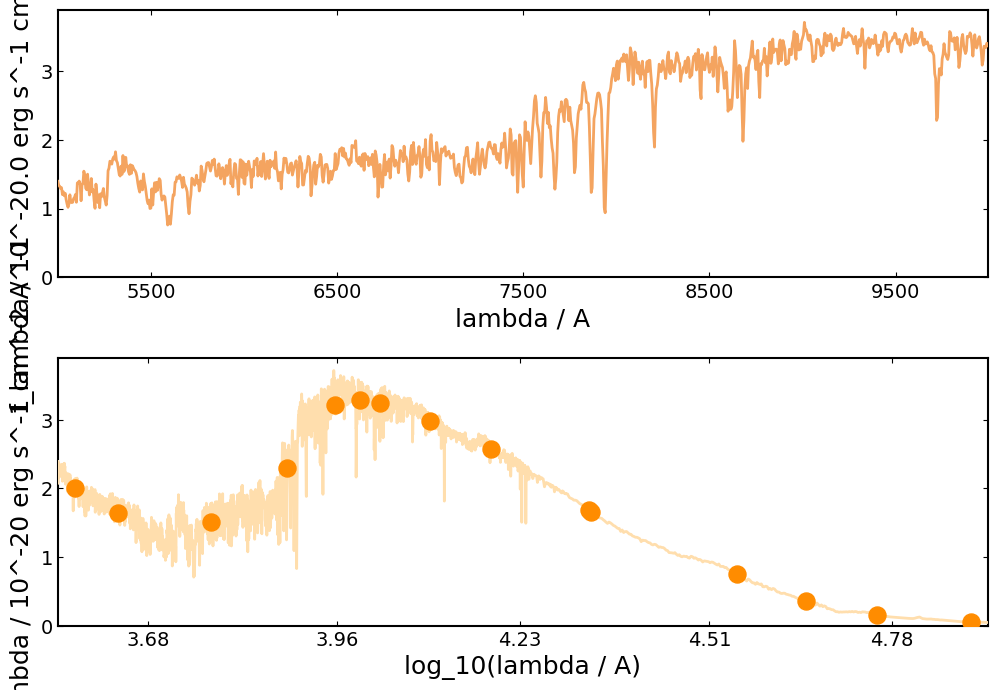

In [18]:
model = pipes.model_galaxy(model_components, filt_list=goodss_filt_list, spec_wavs=np.arange(5000., 10000., 5.))

fig = model.plot()

## 更新模型参数

可以通过更新模型参数来改变输出观测量。相比重建新模型，这通常更快，使用 `update` 方法即可。我们可以修改 model_components 中的数值并传入 `update` 来更新模型光谱。

`update` 方法不支持添加或删除组件（例如添加星云发射），也不支持更改非数值类参数（例如尘埃模型类型）。

{'redshift': 0.5, 'exponential': {'age': 3.0, 'tau': 1.5, 'massformed': 10.0, 'metallicity': 0.5}, 'dust': {'type': 'Calzetti', 'Av': 1.0}}


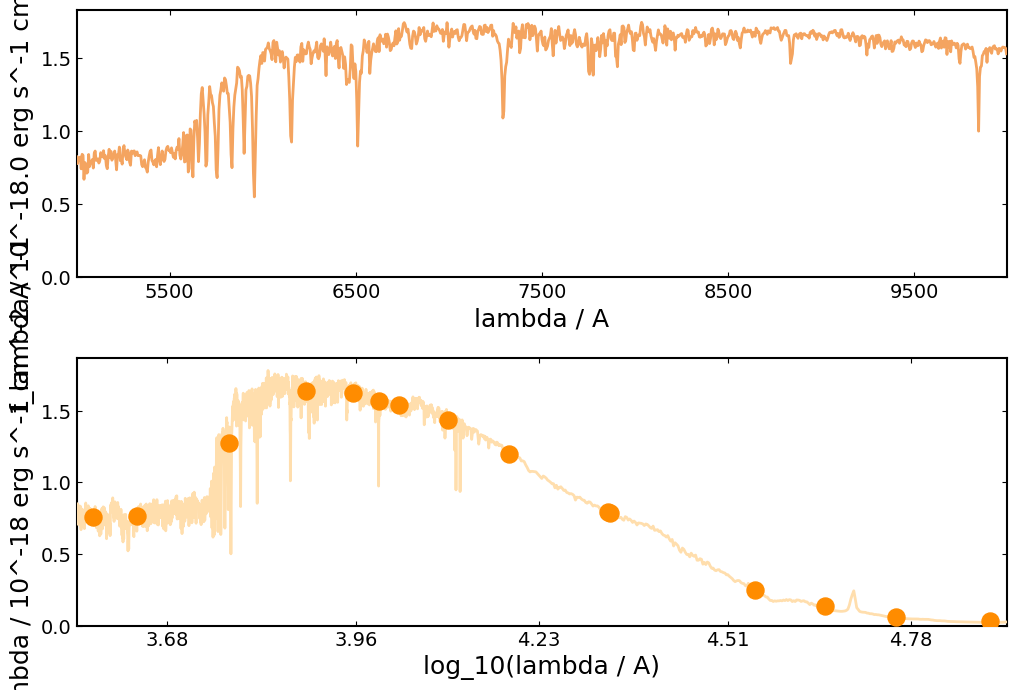

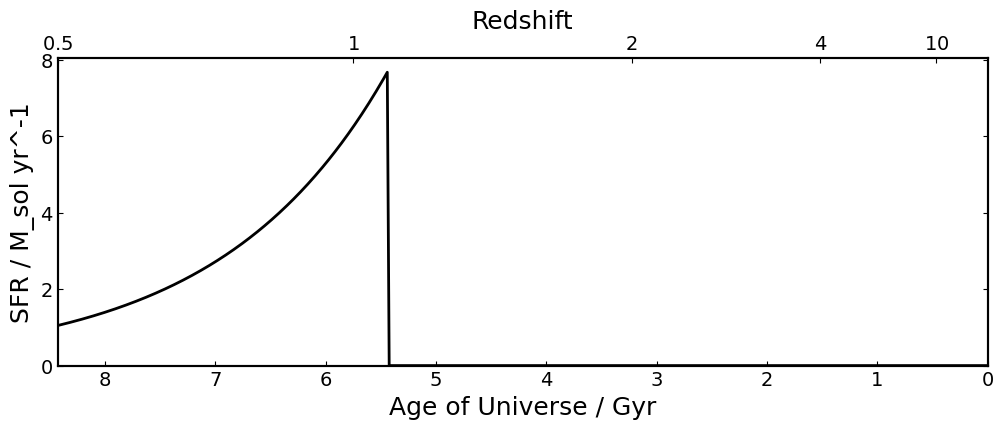

In [19]:
exp["massformed"] = 10.           
exp["tau"] = 1.5
dust["Av"] = 1.0
model_components["redshift"] = 0.5

print(model_components)

model.update(model_components)
fig = model.plot()
fig = model.sfh.plot()

## 为模型增加复杂性 - 星云发射（nebular emission）

下面我们让模型更有趣些：加入星云发射和速度色散（velocity dispersion）。

注意：由于新增了组件，需要重新生成模型，而不能使用只用于更新数值参数的 `update` 方法。

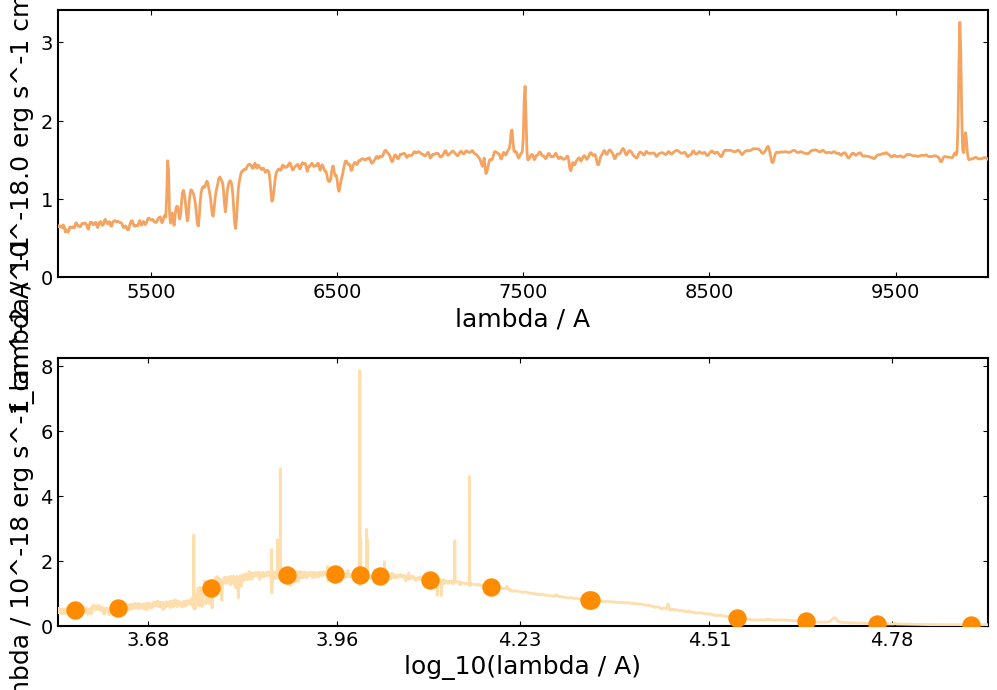

In [20]:
nebular = {}                      # 星云发射组件
nebular["logU"] = -3.             # 电离參數的对数（log10）

dust["eta"] = 3.                  # 年轻恒星的额外尘埃倍数：乘以 Av

model_components["t_bc"] = 0.01         # 出生云寿命（Gyr）
model_components["veldisp"] = 200.      # 速度色散，单位：km/s
model_components["nebular"] = nebular

model = pipes.model_galaxy(model_components, filt_list=goodss_filt_list, spec_wavs=np.arange(5000., 10000., 5.))

fig = model.plot()

## 为模型增加复杂性 - 恒星形成历史

尝试更复杂的恒星形成历史：双幂律（double-power-law）加一些爆发（bursts）。同类组件可通过编号区分：

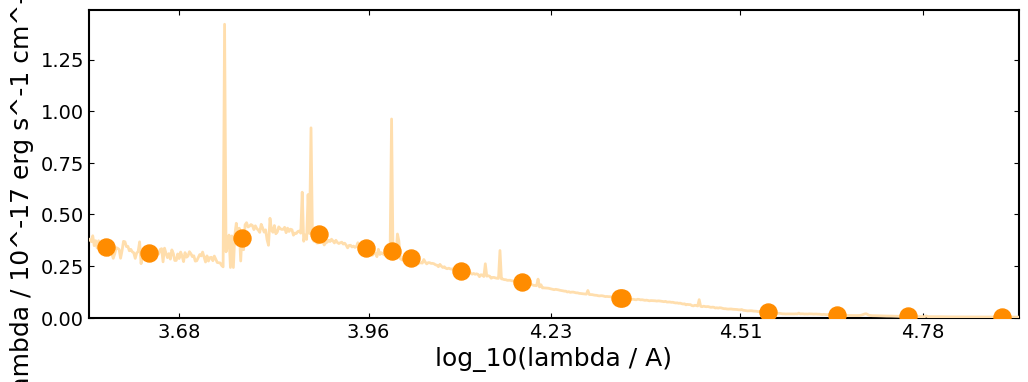

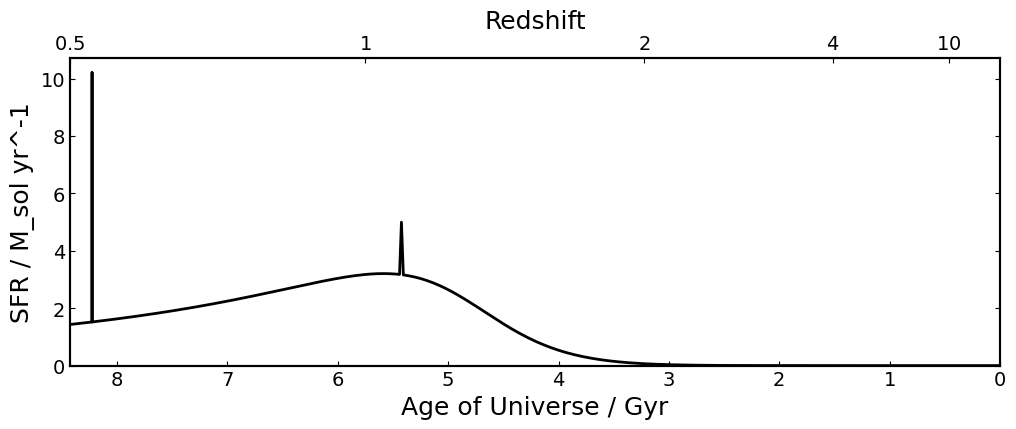

In [21]:
dust = {}                         
dust["type"] = "Calzetti"         
dust["Av"] = 0.2                  
dust["eta"] = 3.                  

nebular = {}                      
nebular["logU"] = -3.             

dblplaw = {}
dblplaw["tau"] = 5.
dblplaw["alpha"] = 2.5
dblplaw["beta"] = 10.
dblplaw["massformed"] = 10.
dblplaw["metallicity"] = 0.5

burst1 = {}
burst1["age"] = 0.2
burst1["massformed"] = 7.
burst1["metallicity"] = 1.

burst2 = {}
burst2["age"] = 3.
burst2["massformed"] = 7.5
burst2["metallicity"] = 0.2

model_components = {}                   
model_components["redshift"] = 0.5
model_components["t_bc"] = 0.01         
model_components["veldisp"] = 200. 
model_components["burst1"] = burst1
model_components["burst2"] = burst2
model_components["dblplaw"] = dblplaw
model_components["dust"] = dust
model_components["nebular"] = nebular

model = pipes.model_galaxy(model_components, filt_list=goodss_filt_list)

fig = model.plot()
sfh = model.sfh.plot()

最后，尝试自定义的恒星形成历史。可以传入一个 numpy 数组，第一列为年龄（年），第二列为恒星形成率（太阳质量/年）：

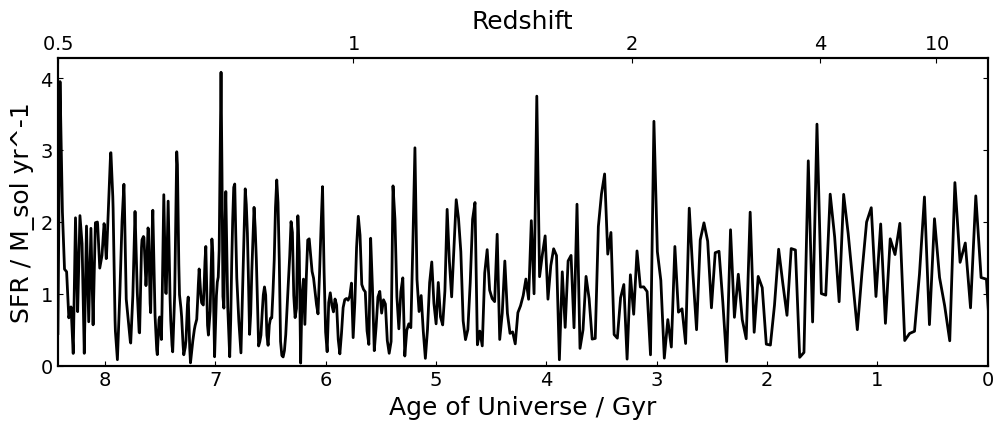

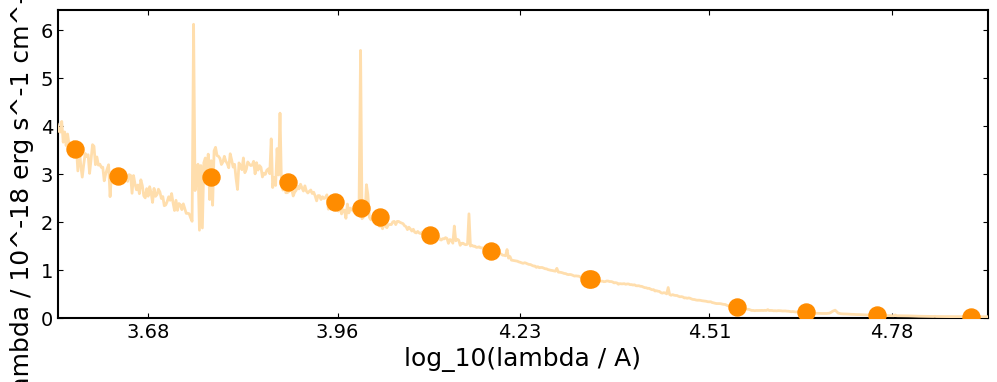

In [22]:
dust = {}                         
dust["type"] = "Calzetti"         
dust["Av"] = 0.2                  
dust["eta"] = 3.                  

nebular = {}                      
nebular["logU"] = -3.             

sfh = np.zeros((500, 2))
sfh[:, 0] = np.arange(0., 10., 0.02)*10**9
sfh[:, 1] = np.abs(np.random.randn(500))

custom = {}
custom["history"] = sfh
custom["massformed"] = 10.
custom["metallicity"] = 1.

model_components = {}                   
model_components["redshift"] = 0.5
model_components["t_bc"] = 0.01         
model_components["veldisp"] = 200. 
model_components["custom"] = custom
model_components["dust"] = dust
model_components["nebular"] = nebular

model = pipes.model_galaxy(model_components, filt_list=goodss_filt_list)

sfh = model.sfh.plot()
fig = model.plot()

## 绘制完整光谱

除了通过 model_galaxy 请求的光谱或光度观测量外，代码还保留了一个覆盖 1 到 10^8 埃范围的参考系内完整光谱模型。该完整光谱存储在 `model_galaxy.spectrum_full`，对应的参考系波长在 `model_galaxy.wavelengths`。可以用以下命令绘制完整光谱：

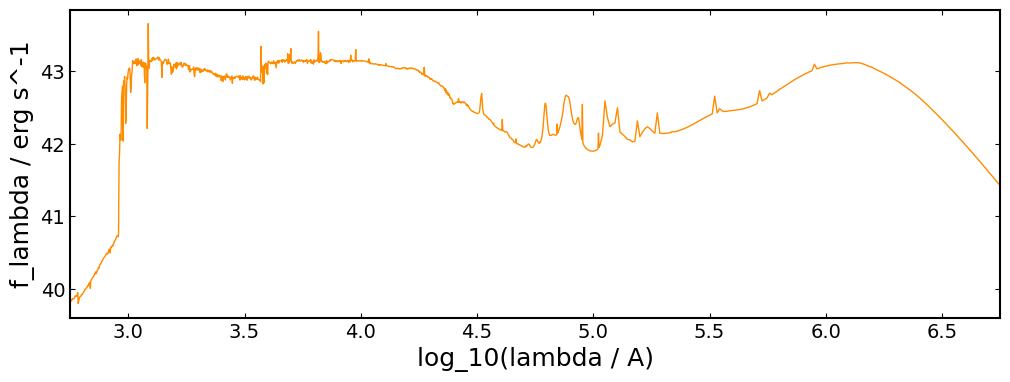

In [23]:
model.plot_full_spectrum()